# Домашнее задание

**Выполнили:**
- Подчезерцев Алексей
- Самоделкина Мария

## Harry Potter and the Action Prediction Challenge from Natural Language

*deadline*: 14 ноября 2022, 23:59

В этом домашнем задании вы будете работать с корпусом Harry Potter and the Action Prediction Challenge. Корпус собран из фанфиков о Гарри Поттере и состоит из двух частей: 1) сырые тексты, 2) фрагменты текстов, описывающих ситуацию, в которой произнесено заклинание.

Корпус описан в статье: https://arxiv.org/pdf/1905.11037.pdf

David Vilares and Carlos Gómez-Rodríguez. Harry Potter and the Action Prediction Challenge from Natural Language. 2019 Annual Conference of the North American Chapter of the Association for Computational Linguistics. To appear.

Код для сбора корпуса находится в репозитории: https://github.com/aghie/hpac . Корпус можно скачать по инструкции из этого репозитория, но для экономии времени авторы задания уже скачали и подготовили данные к работе. 

Ссылки на собранный корпус: 
* Сырые тексты:  https://www.dropbox.com/s/23xet9kvbqna1qs/hpac_raw.zip?dl=0
* Токенизированные тексты в нижнем регистре: https://www.dropbox.com/s/gwfgmomdbetvdye/hpac_lower_tokenized.zip?dl=0
* train-test-dev: https://www.dropbox.com/s/3vdz0mouvex8abd/hpac_splits.zip?dl=0

Части 1, 2 задания должны быть выполнены на полных текстах (сырых или предобработанных -- на ваше усмотрение), Часть 3 – на разбиение на тестовое, отладочное и обучающее множества. Тестовое множество должно быть использовано исключительно для тестирования моделей, обучающее и отладочное – для выбора модели и параметров. 

В статье и репозитории вы найдете идеи, которые помогут вам выполнить домашнее задание. Их стоит воспринимать как руководство к действию, и не стоит их копировать и переиспользовать. Обученные модели использовать не нужно, код для их обучения можно использовать как подсказку. 

## ПРАВИЛА
1. Домашнее задание выполняется в группе до 3-х человек.
2. Домашнее задание оформляется в виде отчета либо в .pdf файле, либо ipython-тетрадке. 
3. Отчет должен содержать: нумерацию заданий и пунктов, которые вы выполнили, код решения, и понятное пошаговое описание того, что вы сделали. Отчет должен быть написан в академическом стиле, без излишнего использования сленга и с соблюдением норм русского языка.
4. Не стоит копировать фрагменты лекций, статей и Википедии в ваш отчет.
5. Отчеты, состоящие исключительно из кода, не будут проверены и будут автоматически оценены нулевой оценкой.
6. Плагиат и любое недобросоветсное цитирование приводит к обнуление оценки. 

## Часть 1. [2 балла] Эксплоративный анализ 
1. Найдите топ-1000 слов по частоте без учета стоп-слов.
2. Найдите топ-10 по частоте: имен, пар имя + фамилия, пар вида ''профессор'' + имя / фамилия. 

[бонус] Постройте тематическую модель по корпусу HPAC.

[бонус] Найдите еще что-то интересное в корпусе (что-то специфичное для фанфиков или фентези-тематики)

In [1]:
import multiprocessing
import os
import pickle
import sys
import zipfile
from collections import Counter

import fasttext
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
tqdm.pandas()

print(f"""{sys.version=}""")
print(f"""{pd.__version__=}""")
print(f"""{np.__version__=}""")

sys.version='3.10.8 (main, Oct 18 2022, 22:21:01) [GCC 9.4.0]'
pd.__version__='1.4.4'
np.__version__='1.23.4'


In [2]:
root = "/home/asciishell/s3/jupyter.asciishell.ru/nlp_hw_1"
root2 = "/home/asciishell/s3/jupyter-storage-1/nlp_hw_1"

In [410]:
data = []
with zipfile.ZipFile(f"{root}/hpac_lower_tokenized.zip") as f:
    for fname in tqdm(f.filelist):
        if fname.compress_size == 0:
            continue
        data.append({"fname": fname.filename, "text": f.read(fname.filename).decode()})
data = pd.DataFrame(data)

  0%|          | 0/36226 [00:00<?, ?it/s]

In [411]:
data.head()

,fname,text
0,hpac_source/4472122,... ` that wand 's more trouble than it 's wor...
1,hpac_source/5214134,it 's quite simple ... . you may look but you ...
2,hpac_source/5287826,i own none of this . jo rowling does . -------...
3,hpac_source/11996224,chapter 1 : next-door neighbours he 's in the ...
4,hpac_source/7887747,a/n : i do not own anything ! this story is wr...


Медианная длина текста - порядка 1000 символов

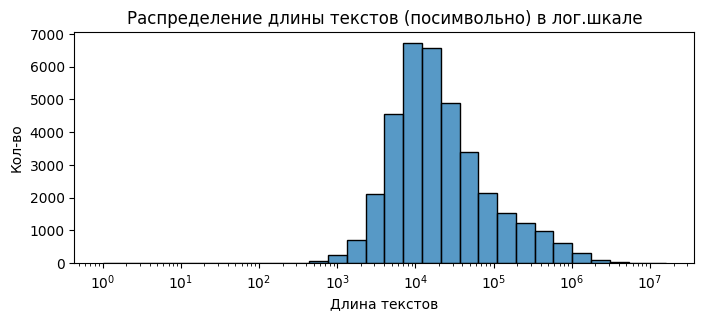

In [5]:
plt.figure(figsize=(8, 3))
sns.histplot(data["text"].map(len), bins=30, log_scale=True)
plt.title("Распределение длины текстов (посимвольно) в лог.шкале")
plt.xlabel("Длина текстов")
plt.ylabel("Кол-во")
plt.show()

### Подсчет всех слов и пар

In [6]:
c = Counter()
c2 = Counter()

stop_words = set(stopwords.words("english"))


def get_tokens(text):
    """
    Разделяет текст по пробелу,
    убирает стоп слова
    и оставляет слова хотя бы с одной буквой (например, пунктуация)
    """
    return [x for x in text.split() if x not in stop_words and any([c.isalpha() for c in x])]


cnt_tokens = []

with multiprocessing.Pool(4) as pool:
    for tokens in tqdm(pool.imap_unordered(get_tokens, data["text"].values), total=len(data)):
        c.update(tokens)
        c2.update([b for b in zip(tokens[:-1], tokens[1:])])
        cnt_tokens.append(len(tokens))

  0%|          | 0/36225 [00:00<?, ?it/s]

In [7]:
cnt_tokens = np.array(cnt_tokens)

Медианное кол-во токенов - порядка 100 на документ

Имеется длинный хвост справа - есть очень длинные тексты

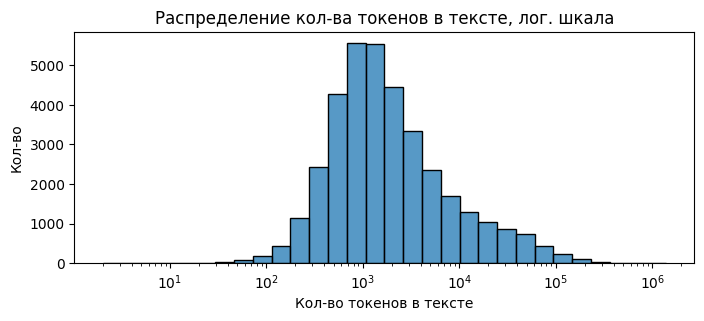

In [8]:
plt.figure(figsize=(8, 3))
sns.histplot(cnt_tokens[cnt_tokens != 0], bins=30, log_scale=True)
plt.title("Распределение кол-ва токенов в тексте, лог. шкала")
plt.xlabel("Кол-во токенов в тексте")
plt.ylabel("Кол-во")
plt.show()

### Топ-1000 всех слов

Сохраняем топ-1000 слов

In [27]:
with open(f"{root2}/top_1000.txt", "wt") as f:
    f.write("\n".join([k.replace("\n", " ") for k, v in c.most_common(1000)]))

Сохраняем счетчик всех токенов

In [12]:
with open(f"{root2}/token_counts.pickle", "wb") as f:
    pickle.dump(c, f)

In [24]:
with open(f"{root2}/token_counts_2.pickle", "wb") as f:
    pickle.dump(c2, f)

In [28]:
!wc {root2}/top_1000.txt

 999 1000 6530 /home/asciishell/s3/jupyter-storage-1/nlp_hw_1/top_1000.txt


In [25]:
c.most_common(10)

[("'s", 4767265),
 ("n't", 4396020),
 ('harry', 3991017),
 ('said', 2262072),
 ('would', 1903185),
 ('hermione', 1826879),
 ('could', 1687864),
 ('back', 1396452),
 ('draco', 1386180),
 ('one', 1376314)]

In [25]:
c2.most_common(10)

[(('harry', "'s"), 392052),
 (('could', "n't"), 388569),
 (('ca', "n't"), 322499),
 (("n't", 'know'), 269490),
 (('would', "n't"), 252957),
 (("n't", 'want'), 201976),
 (('harry', 'said'), 175260),
 (('wo', "n't"), 171073),
 (('draco', "'s"), 163647),
 (('hermione', "'s"), 160459)]

**Вывод:** в наиболее популярные слова входят:
- специфичные для английского языка окончания 's и n't
- имена главных героев harry, hermione, draco
- часто используемые слова для описания действий said, would, could (это может быть специфично только для фанфиков)

Считаем список всех имен

In [39]:
gp_names1 = pd.read_csv(
    "https://gist.githubusercontent.com/jennynz/7eaf7ea4eeb3d686b19e997e721bda0c/raw/82ceec3f5d3717457dd93d0eafa04bc6c3c5913c/harry_potter_all_characters.csv",
    header=None,
)
gp_names2 = pd.read_csv("https://raw.githubusercontent.com/efekarakus/potter-network/master/data/characters.csv")

In [45]:
names = set()
surnames = set()

for elm in gp_names1[0].str.split().values:
    if "." not in elm[0]:
        names.add(elm[0].lower())
    for e in elm[1:]:
        if "." not in e:
            surnames.add(e.lower())

for elm in gp_names2["name"].str.split().values:
    names.add(elm[0].lower())
    for e in elm[1:]:
        surnames.add(e.lower())

### Топ-10 всех имен

In [46]:
c_names = {word: c[word] for word in c if word in names}

In [47]:
Counter(c_names).most_common(10)

[('harry', 3991017),
 ('hermione', 1826879),
 ('draco', 1386180),
 ('ron', 904175),
 ('severus', 654494),
 ('ginny', 637918),
 ('sirius', 628666),
 ('james', 467757),
 ('remus', 432641),
 ('lily', 421348)]

In [57]:
d = np.array(Counter(c_names).most_common(10))

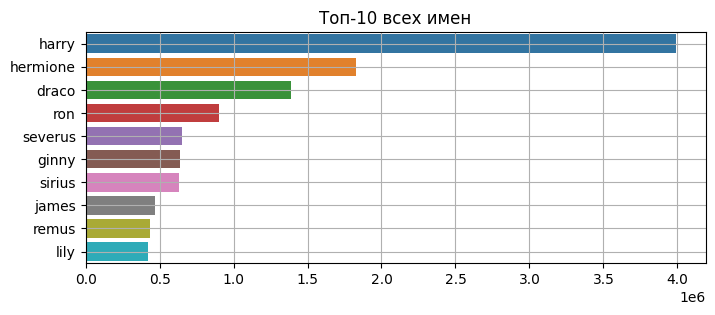

In [65]:
plt.figure(figsize=(8, 3))
sns.barplot(y=d[:, 0], x=d[:, 1].astype(int), orient="h")
plt.title("Топ-10 всех имен")
plt.grid()
plt.show()

### Топ-10 пар имя + фамилия

In [48]:
c2_surnames = {
    pair: c2[pair]
    for pair in c2
    if (pair[0] in names and pair[1] in surnames) or (pair[1] in names and pair[0] in surnames)
}

In [49]:
Counter(c2_surnames).most_common(10)

[(('harry', 'potter'), 134039),
 (('draco', 'malfoy'), 50335),
 (('severus', 'snape'), 33144),
 (('madam', 'pomfrey'), 31875),
 (('hermione', 'granger'), 31672),
 (('james', 'potter'), 29021),
 (('sirius', 'black'), 28009),
 (('lord', 'voldemort'), 27581),
 (('lucius', 'malfoy'), 25112),
 (('albus', 'dumbledore'), 22489)]

In [66]:
d = np.array(Counter(c2_surnames).most_common(10))

/tmp/ipykernel_1603/2619843258.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  d = np.array(Counter(c2_surnames).most_common(10))


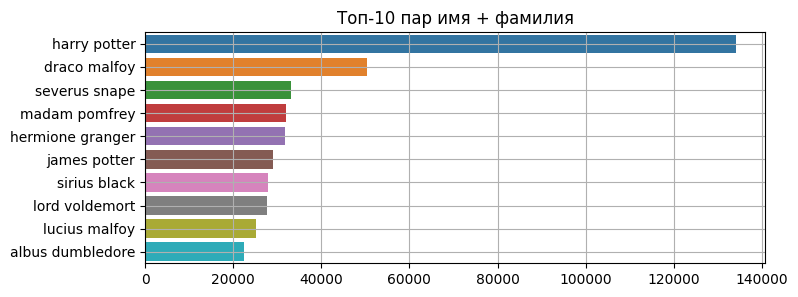

In [75]:
plt.figure(figsize=(8, 3))
sns.barplot(y=[p[0] + " " + p[1] for p in d[:, 0]], x=d[:, 1].astype(int), orient="h")
plt.title("Топ-10 пар имя + фамилия")
plt.grid()
plt.show()

### Топ-10 пар профессор + имя/фамилия

In [50]:
c2_professor = {pair: c2[pair] for pair in c2 if pair[0] == "professor" and (pair[1] in names or pair[1] in surnames)}

In [52]:
Counter(c2_professor).most_common(10)

[(('professor', 'snape'), 46039),
 (('professor', 'mcgonagall'), 43118),
 (('professor', 'dumbledore'), 24439),
 (('professor', 'lupin'), 10162),
 (('professor', 'flitwick'), 9570),
 (('professor', 'slughorn'), 5905),
 (('professor', 'sprout'), 5788),
 (('professor', 'harry'), 4669),
 (('professor', 'trelawney'), 3188),
 (('professor', 'umbridge'), 2917)]

In [123]:
d = np.array(Counter(c2_professor).most_common(10))

/tmp/ipykernel_1603/716138064.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  d = np.array(Counter(c2_professor).most_common(10))


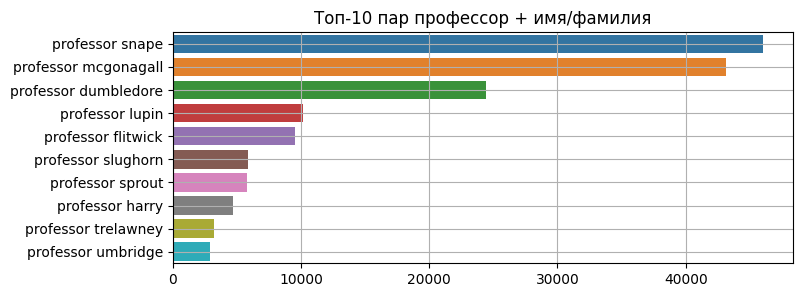

In [124]:
plt.figure(figsize=(8, 3))
sns.barplot(y=[p[0] + " " + p[1] for p in d[:, 0]], x=d[:, 1].astype(int), orient="h")
plt.title("Топ-10 пар профессор + имя/фамилия")
plt.grid()
plt.show()

**Вывод:**
- Топ-10 всех имен в целом соответствует главным персонажам основного произведения. Возможно есть некоторые смещение относительно важности персонажей (тут вычисляется только частота встречаемости) и частоты оригинального произведения, поскольку фанфики могут быть написаны по без учета важности персонажей, поскольку не нужно соблюдать сюжетную линию, можно писать отрывками про любых (наиболее интересных) персонажей
- Топ-10 пар имя + фамилия получились корректными
- Не все герои из топ-10 пар профессор + имя/фамилия действительно являются профессорами, возможно, данные сочетания просто часто встречались рядом в предложении (после исключения стоп слов это вполне возможно)

### Специфика фанфиков

На основе фильма "Гарри Поттер и Философский камень" была проведена аналитика https://www.kaggle.com/code/eward96/harry-potter-character-analysis

На картинке представлена статистика по кол-ву реплик каждого героя

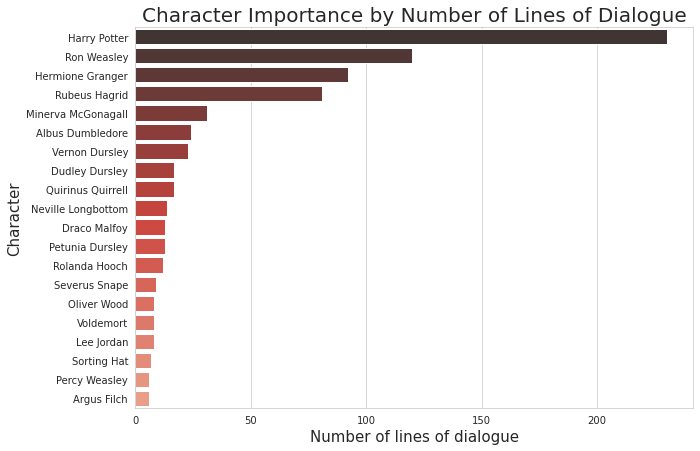

Как мы видим, данная статистика отличается от Топ-10 имен и Топ-10 пар имя + фамилия, поскольку в фанфиках акцент может быть сделан на других персонажах.


## Часть 2. [2 балла] Модели представления слов 
Обучите модель представления слов (word2vec, GloVe, fastText или любую другую) на материале корпуса HPAC.
1. Продемонстрируйте, как работает поиск синонимов, ассоциаций, лишних слов в обученной модели. 
2. Визуализируйте топ-1000 слов по частоте без учета стоп-слов (п. 1.1) с помощью TSNE или UMAP (https://umap-learn.readthedocs.io).

In [3]:
import re

regex = re.compile("[a-zA-Z]+")

In [440]:
fasttext_file = f"{root2}/lower_tokenized.txt"
fasttext_model = f"{root2}/fasttext_v2.bin"

if not os.path.exists(fasttext_file):
    data["text"].progress_map(lambda x: ' '.join(regex.findall(x))).to_csv(
        fasttext_file, index=False, header=None
    )

  0%|          | 0/36225 [00:00<?, ?it/s]

In [441]:
!ls -alish {fasttext_model}*

ls: cannot access '/home/asciishell/s3/jupyter-storage-1/nlp_hw_1/fasttext_v2.bin*': No such file or directory


In [442]:
if not os.path.exists(fasttext_model + ".bin")  or not os.path.exists(fasttext_model + ".vec") :
    !/home/asciishell/project/fastText/fasttext \
    cbow \
    -input {fasttext_file} \
    -output {fasttext_model} \
    -epoch 5 \
    -lr 0.05 \
    -thread 32

Read 503M words
Number of words:  111925
Number of labels: 0
Progress: 100.0% words/sec/thread:  139742 lr:  0.000000 avg.loss:  1.737872 ETA:   0h 0m 0s  0h 9m 7s 2.077647 ETA:   0h 8m53s 2.064973 ETA:   0h 8m50s avg.loss:  2.051870 ETA:   0h 8m43s 2.043540 ETA:   0h 8m31sh 8m28s  0h 8m20s 2.038385 ETA:   0h 8m18s avg.loss:  2.038783 ETA:   0h 8m15sm 7s ETA:   0h 7m46sh 7m40sm30s 2.018216 ETA:   0h 7m24sh 7m17s avg.loss:  2.015852 ETA:   0h 7m11s  0h 6m55s 2.013160 ETA:   0h 6m53s 2.004474 ETA:   0h 6m13s avg.loss:  2.003805 ETA:   0h 6m11s  0h 6m 3s  0h 6m 1s 1.998038 ETA:   0h 5m45s 1.997670 ETA:   0h 5m42s ETA:   0h 5m34s avg.loss:  1.993212 ETA:   0h 5m26s 5m13sh 5m11sh 4m55s 1.969611 ETA:   0h 4m40s21s 3m54s 1.911073 ETA:   0h 3m48s 1.906567 ETA:   0h 3m43s 1.902233 ETA:   0h 3m38s 1.897849 ETA:   0h 3m33s 2m58s 1.844877 ETA:   0h 2m32s avg.loss:  1.841545 ETA:   0h 2m27s 1.835082 ETA:   0h 2m18s 1.832959 ETA:   0h 2m15s 1.829378 ETA:   0h 2m10s 2m 0s 1m39s 0.008619 avg.loss:  1.

In [ ]:
# Другой вариант модели (fasttext.bin)
# !/home/asciishell/project/fastText/fasttext \
# skipgram \
# -input {fasttext_file} \
# -output {fasttext_model} \
# -epoch 10 \
# -lr 0.05 \
# -thread 16

In [49]:
fasttext_model = f"{root2}/fasttext.bin"

model = fasttext.load_model(fasttext_model + ".bin")

### Синонимы

In [50]:
model.get_nearest_neighbors("potion")

[(0.8646436333656311, 'brewed'),
 (0.858086109161377, 'concoction'),
 (0.8546221256256104, 'pain-potion'),
 (0.846133828163147, 'brew'),
 (0.8435521721839905, 'antidote'),
 (0.8288614153862, 'decoction'),
 (0.8245982527732849, 'concoctions'),
 (0.8179044723510742, 'blood-replenishing'),
 (0.8176730275154114, 'draught'),
 (0.809573769569397, 'spy-potion')]

In [51]:
model.get_nearest_neighbors("ron")

[(0.8995552659034729, 'ginny'),
 (0.8542776703834534, 'hermione'),
 (0.827785313129425, 'dean'),
 (0.8188828825950623, 'george'),
 (0.8167181015014648, 'harry'),
 (0.81087327003479, 'seamus'),
 (0.8089451193809509, 'fred'),
 (0.7860161662101746, 'hermoine'),
 (0.7829092741012573, 'charlie'),
 (0.7789359092712402, 'neville')]

In [52]:
model.get_nearest_neighbors("broomstick")

[(0.9495965242385864, 'broom'),
 (0.8949041962623596, 'firebolt'),
 (0.8390422463417053, 'brooms'),
 (0.8362292647361755, 'cleansweep'),
 (0.831422746181488, 'nimbus'),
 (0.8250163197517395, 'cleansweeper'),
 (0.8098112940788269, 'nimbuses'),
 (0.802336573600769, 'broomhead'),
 (0.7986066341400146, 'firebold'),
 (0.7893670201301575, 'cleansweeps')]

**Вывод:**
- некоторые слова являются достаточно точными синонимами, однако встречаются также и не совсем походящие слова (на зелье и вошлебную палочку получились очень хорошие и объяснимые синонимы)

- заметили, что модель cbow в качестве синонимов предлагает больше слов, схожих по написанию; в то время как модель с skip gram выдавала более интересные и отличающиеся синонимы

### Ассоциации

Ассоциация на волшебную метлу / квиддич удалась

In [53]:
model.get_analogies("stick", "wand", "broom")

[(0.7115725874900818, 'broomstick'),
 (0.6647584438323975, 'broomhead'),
 (0.6558730602264404, 'quiddittch'),
 (0.6479772925376892, 'brooms'),
 (0.6425372362136841, 'cleansweeper'),
 (0.6409185528755188, 'quiddinch'),
 (0.6368589997291565, 'brooming'),
 (0.6239717602729797, 'broome'),
 (0.6211232542991638, 'broom-care'),
 (0.6138243079185486, 'ride')]

Ассоциация не удалась - ожидали увидеть бороду/шляпу. Но полученный результат объясним тем, что в фанфиках такой тонкости о внешности может не сожержаться

In [54]:
model.get_analogies("harry", "thunder", "dumbledore")

[(0.7226178646087646, 'umbledore'),
 (0.7100072503089905, 'dumlbedore'),
 (0.7085336446762085, 'memory-dumbledore'),
 (0.703728973865509, 'bumbledore'),
 (0.7032822966575623, '"dumbledore'),
 (0.7019404172897339, 'snape-dumbledore'),
 (0.6982855200767517, 'dumbeldore'),
 (0.6967118978500366, 'headmaster'),
 (0.6945318579673767, 'dumbled'),
 (0.6931195259094238, 'dombledore')]

In [55]:
model.get_analogies("harry", "glasses", "dumbledore")

[(0.6996369957923889, 'dombledore'),
 (0.6992602348327637, 'mcgonagall-dumbledore'),
 (0.6962229609489441, 'snape-dumbledore'),
 (0.6860343813896179, '"dumbledore'),
 (0.6843746900558472, 'dumbledor'),
 (0.6816670894622803, 'not-mcgonagall'),
 (0.6768199801445007, 'headmaster'),
 (0.6761587858200073, 'ron-dumbledore'),
 (0.6736249327659607, 'dumbleore'),
 (0.6676123738288879, 'umbledore')]

Ассоциация не удалась, ожидали увидеть Слизерин. Вероятно в фанфиках на этом не заостряют внимание

In [56]:
model.get_analogies("ron", "gryffindor", "malfoy")

[(0.7603804469108582, 'draco'),
 (0.6836978197097778, 'lucius'),
 (0.6693409085273743, 'harry'),
 (0.664298951625824, 'hermione'),
 (0.6612650752067566, 'malf'),
 (0.6604340672492981, 'blaise'),
 (0.6553623080253601, 'malfo'),
 (0.6433576941490173, 'theo'),
 (0.6343098282814026, 'bill'),
 (0.6269938945770264, 'percy')]

### t-SNE

In [126]:
from sklearn.manifold import TSNE

In [127]:
with open(f"{root2}/top_1000.txt", "rt") as f:
    texts = f.readlines()

embeds = np.stack([model.get_word_vector(x) for x in texts])
embeds_tsne = TSNE(n_components=2, random_state=42, learning_rate="auto", init="pca").fit_transform(embeds)

/home/asciishell/project/venv3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


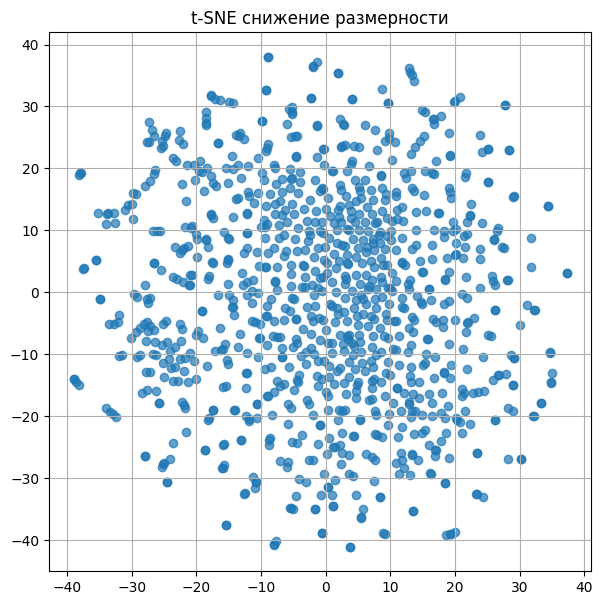

In [130]:
plt.figure(figsize=(7, 7))
plt.scatter(*embeds_tsne.T, alpha=0.7)
plt.title('t-SNE снижение размерности')
plt.grid()
plt.show()

Примеры слов в дали от центра

In [148]:
print(*np.array(texts)[(abs(embeds_tsne) > 25).all(axis=1)])

magic
 father
 family
 parents
 wizard
 potion
 potions
 eaters
 magical
 wizards
 eater
 wizarding
 alley



Примеры слов в центре

In [150]:
print(*np.array(texts)[(abs(embeds_tsne) < 3).all(axis=1)])

would
 could
 one
 see
 go
 let
 done
 gone
 deep
 ago
 free
 christmas
 fun
 gotten



**Вывод:**
- визуализация представляет собой достаточно плотное облако точек, отдельные кластера не выделяются, однако есть некоторые слова, которые находятся вдали от основного центра
- слова из центра - часто употребляемые слова действий, предлоги. Слова в дали от цетра - менее частые, но широкоиспользуемые в рассматриваемом произведении

## Часть 3. [5 баллов] Классификация текстов
Задача классификации формулируется так: данный фрагмент фанфика описывают какую-то ситуацию, которая предшествует произнесению заклинания. Требуется по тексту предсказать, какое именно заклинание будет произнесено. Таким образом, заклинание - это фактически метка класса. Основная мера качества – macro $F_1$.
Обучите несколько классификаторов и сравните их между собой. Оцените качество классификаторов на частых и редких классах. Какие классы чаще всего оказываются перепутаны? Связаны ли ошибки со смыслом заклинаний?

Используйте фрагменты из множества train для обучения, из множества dev для отладки, из множества test – для тестирования и получения итоговых результатов. 

1. [1 балл] Используйте fastText в качестве baseline-классификатора.
2. [2 балла] Используйте сверточные  или реккурентные сети в качестве более продвинутого классификатора. Поэкспериментируйте с количеством и размерностью фильтров, используйте разные размеры окон, попробуйте использовать $k$-max pooling. 
3. [2 балла] Попробуйте расширить обучающее множество за счет аугментации данных. Если вам понадобится словарь синонимов, можно использовать WordNet (ниже вы найдете примеры).

[бонус] Используйте результат max pooling'а как эмбеддинг входного текста. Визуализируйте эмбеддинги 500-1000 предложений из обучающего множества и изучите свойства получившегося пространства.

[бонус] Используйте ваш любимый классификатор и любые (честные) способы повышения качества классификации и получите macro $F_1$ больше 0.5.

In [4]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [5]:
df_train = pd.read_csv(f"{root}/hpac_corpus/hpac_training_128.tsv", sep="\t", header=None, names=["rnd", "target", "text"])
df_dev = pd.read_csv(f"{root}/hpac_corpus/hpac_dev_128.tsv", sep="\t", header=None, names=["rnd", "target", "text"])
df_test = pd.read_csv(f"{root}/hpac_corpus/hpac_test_128.tsv", sep="\t", header=None, names=["rnd", "target", "text"])

### FastText

In [446]:
fasttext_file = f"{root2}/train.txt"
fasttext_model = f"{root2}/fasttext_clf_v2"

if not os.path.exists(fasttext_file):
    df_train.assign(label=df_train["target"].map(lambda x: "__label__" + x))[["label", "text"]].to_csv(
        fasttext_file, index=False, header=None, sep=" ", quotechar="", escapechar=" ", quoting=3
    )
    
    df_dev.assign(label=df_dev["target"].map(lambda x: "__label__" + x))[["label", "text"]].to_csv(
        fasttext_file + ".dev", index=False, header=None, sep=" ", quotechar="", escapechar=" ", quoting=3
    )

Обучаем fasttext на основе unsupervised претрейна из 2 части.

In [447]:
if not os.path.exists(fasttext_model + ".bin")  or not os.path.exists(fasttext_model + ".vec"):
    !/home/asciishell/project/fastText/fasttext supervised  \
        -input {fasttext_file} \
        -output {fasttext_model} \
        -autotune-validation {fasttext_file}.dev \
        -thread 32 \
        # -epoch 5 \
        # -lr 0.9 \
        -pretrainedVectors {root2}/fasttext_v2.bin \
        # -dim 64


Progress: 100.0% Trials:   12 Best score:  0.309665 ETA:   0h 0m 0s 4ss ETA:   0h 2m46s
Training again with best arguments
Read 7M words
Number of words:  58022
Number of labels: 85
Progress: 100.0% words/sec/thread: 1107650 lr:  0.000000 avg.loss:  1.121292 ETA:   0h 0m 0s  0h 0m16sh 0m14s 0.046568 avg.loss:  1.963928 ETA:   0h 0m11s


In [448]:
model = fasttext.load_model(fasttext_model + ".bin")

In [449]:
for name, sample in [('train', df_train), ('dev', df_dev), ('test', df_test)]:
    score = f1_score(
        sample["target"],
        [x[0].replace("__label__", "") for x in model.predict(list(sample["text"].values))[0]],
        average="macro",
    )
    print(f"Sample {name}\tscore:{score:.4f}")

Sample train	score:0.5239
Sample dev	score:0.1220
Sample test	score:0.1168


Получили f1 macro на тестовой выборке равное 0.1168, а на обучающей - 0.5239.
Модель переобучена и хорошо запоминает выборку, но не генерализирует тексты.

### Neural Network

In [6]:
import functools

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils
from nltk.corpus import wordnet as wn
from sklearn.metrics import log_loss
from torch import nn
from torch.utils.tensorboard import SummaryWriter

print(f"""{torch.__version__=}""")

torch.__version__='1.12.1+cu102'


In [7]:
# fasttext_model = fasttext.load_model(f"{root2}/fasttext_clf_tuned.bin")
fasttext_model = fasttext.load_model(f"{root2}/fasttext_v2.bin.bin")

In [8]:
class Mapper:
    """
    Вспомогательный класс для преобразования строк в порядковые числительные
    """
    def __init__(self, init_id=0, unk_id=None):
        self.map = {}
        self.last_i = init_id
        self.unk_id = unk_id
        self.freezed = False
        
    def __call__(self, x):
        if x not in self.map and not self.freezed:
            self.map[x] = self.last_i
            self.last_i += 1
        return self.map.get(x, self.unk_id)
    
    def reverse(self):
        return {v: k for k, v in self.map.items()}
    
    def freeze(self):
        self.freezed = True

In [9]:
# Преобразуем строковое описание целевой переменной в число
target_mapper = Mapper()
df_train["target"].map(target_mapper)
target_mapper.freeze()
assert df_dev["target"].map(target_mapper).isna().sum() == 0
assert df_test["target"].map(target_mapper).isna().sum() == 0

In [10]:
MAX_LEN = 128
MAX_TOKENS = 60000
BATCH_SIZE = 128

In [11]:
# Преобразуем токены в числа, 0 - пустой, 1 - неизвестный спец токен

c = Counter()
stop_words = set(stopwords.words("english"))
# stop_words = set()
df_train["text"].map(lambda x: c.update([xx for xx in (' '.join(regex.findall(x))).split() if xx not in stop_words]))
token_mapper = Mapper(init_id=2, unk_id=1)
for k, v in c.most_common()[:MAX_TOKENS]:
    if v <= 1:
        continue
    token_mapper(k)
token_mapper.freeze()


Проинициализируем матрицу эбмеддингов из unsupervised претрейна из этапа 1.

In [12]:
embed_matrix = []
reverse = token_mapper.reverse()
filled = 0
for i in range(token_mapper.last_i):
    vec = None
    if i in reverse:
        vec = fasttext_model.get_word_vector(reverse[i])
    if vec is None:
        # vec = np.random.normal(size=fasttext_model.get_dimension())
        vec = np.zeros(fasttext_model.get_dimension())
    else:
        filled += 1
    embed_matrix.append(vec)
embed_matrix = np.stack(embed_matrix)
print("Init rate: ", filled / len(embed_matrix))

Init rate:  0.9999386446605516


In [13]:
# # Пример инициализации из эмбеддингов, обученных на википедии
# embed_matrix = {}
# reverse = token_mapper.reverse()
# filled = 0
# with open(f"{root}/wiki-news-300d-1M.vec", "rt") as f:
#     size, emb = map(int, f.readline().split())
#     for i in tqdm(range(size)):
#         token, vec = f.readline().split(maxsplit=1)
#         pos = token_mapper(token.lower())
#         if pos > token_mapper.unk_id:
#             vec = list(map(float, vec.split()))
#             embed_matrix[pos] = vec
#             # filled += 1
# for i in range(token_mapper.last_i):
#     if i not in embed_matrix:
#         # vec = np.random.normal(size=emb)
#         vec = np.zeros(emb)
#         embed_matrix[i] = vec
#     else:
#         filled += 1
# embed_matrix = [embed_matrix[i] for i in range(token_mapper.last_i)]
# embed_matrix = np.stack(embed_matrix)
# print("Init rate: ", filled / len(embed_matrix))

In [36]:
# Датасет для задачи. Для каждого текста вернем набор id токенов и соответствующий id целевой переменной.

class HPACDataset(torch.utils.data.Dataset):
    def __init__(self, df, token_mapper, target_mapper, max_len):
        df = df.sample(frac=1.0)
        self.texts = df["text"].values.copy()
        self.target = df["target"].values.copy()
        self.token_mapper = token_mapper
        self.target_mapper = target_mapper
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = " ".join(regex.findall(self.texts[idx])).split()
        tokens = [self.token_mapper(x) for x in tokens][:self.max_len]
        if len(tokens) < self.max_len:
            tokens += [0] * (self.max_len - len(tokens))

        return np.array(tokens), np.int32(self.target_mapper(self.target[idx]))


@functools.lru_cache()
def get_synonim(word):
    synonims = []
    for a in wn.synsets(word):
        for b in a.lemmas():
            synonims.append(b.name())
    if len(synonims) == 0:
        return [word]
    return synonims


class HPACAugDataset(torch.utils.data.Dataset):
    """
    Аугментированный датасет.
    Для replace_tokens токенов заменим слово на случайный синоним.
    
    """
    def __init__(self, df, token_mapper, target_mapper, max_len, replace_tokens=0.3):
        df = df.sample(frac=1.0)
        self.texts = df["text"].values.copy()
        self.target = df["target"].values.copy()
        self.token_mapper = token_mapper
        self.target_mapper = target_mapper
        self.max_len = max_len
        self.replace_tokens = replace_tokens
        self.rnd = np.random.default_rng()

    def __len__(self):
        return len(self.texts)

    def _aug_seq(self, token_seq):
        return [self.rnd.choice(get_synonim(x)) if self.rnd.random() < self.replace_tokens else x for x in token_seq]

    def __getitem__(self, idx):
        tokens = " ".join(regex.findall(self.texts[idx])).split()
        tokens = [self.token_mapper(x) for x in self._aug_seq(tokens)][:self.max_len]
        if len(tokens) < self.max_len:
            tokens += [0] * (self.max_len - len(tokens))

        return np.array(tokens), np.int32(self.target_mapper(self.target[idx]))

In [37]:
# Нейронная сеть на основе LSTM, работает медленно и показывает низкое качество, использовалась на первых итерациях
class Network(torch.nn.Module):
    """
    Нейронная сеть на основе LSTM
    """
    def __init__(
        self, num_embeddings=None, embedding_dim=None, embedding_weights=None, hidden_dim=32, seq_len=128, num_class=85
    ):
        super().__init__()
        if embedding_weights is not None:
            self.emb = nn.Embedding.from_pretrained(embedding_weights, freeze=False, padding_idx=0)
            embedding_dim = embedding_weights.shape[1]
        else:
            self.emb = torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = torch.nn.Linear(hidden_dim * seq_len, num_class)

    def forward(self, inp):
        x = self.emb(inp)
        x, (f0, f0) = self.lstm(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        x = F.softmax(x, dim=1)
        return x


class KMaxPooling(torch.nn.Module):
    """
    Реализация kmax pooling
    Отбирает k максимальных значений признака
    """
    def __init__(self, dim, k):
        super().__init__()
        self.dim = dim
        self.k = k

    def forward(self, x):
        index = x.topk(self.k, dim=self.dim)[1].sort(dim=self.dim)[0]
        return x.gather(self.dim, index)


class Network2(torch.nn.Module):
    """
    Нейронная сеть на основе сверток
    """
    def __init__(
        self,
        *,
        num_embeddings=None,
        embedding_dim=None,
        embedding_weights=None,
        hidden_dim=32,
        seq_len=128,
        num_class=85,
        layer_cnt=3,
        hidden_mul=2,
        kernel_size=3,
        kmax_pool_dec=None,
        extra_dropout=False,
    ):
        """
        num_embeddings - количество токенов в эмбеддингах
        embedding_dim - размерность эмбеддинга
        embedding_weights - матрица инициализации эмбеддингов
        hidden_dim - размерность начального скрытого представления
        seq_len - исходная длина последовательности
        num_class - количество классов
        layer_cnt - количество "пачек" слоев (cnn, relu, cnn, bn, relu, maxpool, dp)
        hidden_mul - мультипликатор размерности скрытого состояния
        kernel_size - размер ядра для сверточных слоев
        kmax_pool_dec - декремент размерности для kmax pooling или None для max pooling
        extra_dropout - добавить Dropout для векторов эмбеддингов (занулить некоторые токены)
        """
        super().__init__()
        if embedding_weights is not None:
            self.emb = nn.Embedding.from_pretrained(embedding_weights, freeze=False, padding_idx=0)
            embedding_dim = embedding_weights.shape[1]
        else:
            self.emb = torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        
        self.layers = []
        if extra_dropout is not None:
            self.layers.append(nn.Dropout2d(p=extra_dropout))
            
        init_dim = embedding_dim
        middle_dim = hidden_dim
        current_seq_len = seq_len

        for i in range(layer_cnt):
            if kmax_pool_dec is None:
                pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=2)
            else:
                pool = KMaxPooling(dim=2, k=int(current_seq_len / kmax_pool_dec))
            layer = nn.Sequential(
                nn.Conv1d(init_dim, middle_dim, kernel_size=kernel_size, padding=1),
                nn.LeakyReLU(0.1),
                nn.Conv1d(middle_dim, middle_dim, kernel_size=kernel_size, padding=1),
                nn.BatchNorm1d(middle_dim),
                nn.LeakyReLU(0.1),
                pool,
                nn.Dropout(0.2),
            )
            self.layers.append(layer)
            init_dim = middle_dim
            middle_dim = int(middle_dim * hidden_mul)
            # CEIL((L_in + 2 * padding - dillation * (kernel_size - 1) - 1) / stride + 1)
            current_seq_len = int((current_seq_len + 2 * 1 - 1 * (kernel_size - 1) - 1) / 1 + 1) # conv1
            current_seq_len = int((current_seq_len + 2 * 1 - 1 * (kernel_size - 1) - 1) / 1 + 1) # conv2
            if kmax_pool_dec is None:
                current_seq_len = int((current_seq_len + 2 * 1 - 2 * (2 - 1) - 1) / 2 + 1) # max pooling
            else:
                current_seq_len = int(current_seq_len / kmax_pool_dec)
        self.layers = nn.Sequential(*self.layers)
        self.linear = torch.nn.Linear(init_dim * current_seq_len, num_class)

    def forward(self, inp):
        x = self.emb(inp)
        x = torch.transpose(x, 1, 2)
        x = self.layers(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        # x = F.softmax(x, dim=1)
        return x

In [27]:
from sklearn.metrics import roc_auc_score
import scipy

In [38]:
def train_loop(
    *, train_loader, val_loader, test_loader, num_epochs, network, criterion, optimizer, writer, checkpoint_path
):
    """
    Основная функция обучения - на каждой эпохе проходимся по обучающей выборке, в конце эпохи считаем метрики и сохраняем состояние
    """
    step = 0
    labels = np.arange(85)
    for epoch in tqdm(range(num_epochs)):
        predicts = []
        targets = []
        for batch_tokens, batch_target in train_loader:
            optimizer.zero_grad()
            network.train()

            predict = network(batch_tokens)
            loss = criterion(predict, batch_target.long())
            loss.backward()
            optimizer.step()
            predicts.extend(predict.detach().cpu().numpy())
            targets.extend(batch_target.detach().cpu().numpy())
            writer.add_scalar("train/loss", loss, step)

            step += 1
        predicts = np.stack(predicts)
        targets = np.stack(targets)
        writer.add_scalar("train/f1", f1_score(targets, predicts.argmax(axis=1), average="macro"), epoch)
        writer.add_scalar("train/f1w", f1_score(targets, predicts.argmax(axis=1), average="weighted"), epoch)
        writer.add_scalar("train/roc_auc", roc_auc_score(targets, scipy.special.softmax(predicts, axis=1), multi_class="ovo", labels=labels), epoch)

        with torch.no_grad():
            network.eval()
            predicts = []
            targets = []
            for batch_tokens, batch_target in val_loader:
                predict = network(batch_tokens)
                predicts.extend(predict.cpu().numpy())
                targets.extend(batch_target.cpu().numpy())
            predicts = np.stack(predicts)
            targets = np.stack(targets)
            writer.add_scalar("valid/f1", f1_score(targets, predicts.argmax(axis=1), average="macro"), epoch)
            writer.add_scalar("valid/f1w", f1_score(targets, predicts.argmax(axis=1), average="weighted"), epoch)
            writer.add_scalar(
                "valid/roc_auc", roc_auc_score(targets, scipy.special.softmax(predicts, axis=1), multi_class="ovo", labels=labels), epoch
            )

            predicts = []
            targets = []
            for batch_tokens, batch_target in test_loader:
                predict = network(batch_tokens)
                predicts.extend(predict.cpu().numpy())
                targets.extend(batch_target.cpu().numpy())
            predicts = np.stack(predicts)
            targets = np.stack(targets)
            writer.add_scalar("test/f1", f1_score(targets, predicts.argmax(axis=1), average="macro"), epoch)
            writer.add_scalar("test/f1w", f1_score(targets, predicts.argmax(axis=1), average="weighted"), epoch)
            writer.add_scalar("test/roc_auc", roc_auc_score(targets, scipy.special.softmax(predicts, axis=1), multi_class="ovo", labels=labels), epoch)
            torch.save(network.state_dict(), checkpoint_path.format(epoch))

In [39]:
# Список финальных экспериментов
tasks = [
    {"layers": 3, "kernel_size": 3, "dataset": HPACDataset(df_train, token_mapper, target_mapper, MAX_LEN), "name": "logs2_layers=3_kernel=3"},
    {"layers": 2, "kernel_size": 5, "dataset": HPACDataset(df_train, token_mapper, target_mapper, MAX_LEN), "name": "logs2_layers=2_kernel=5"},
    {"layers": 3, "kernel_size": 5, "dataset": HPACDataset(df_train, token_mapper, target_mapper, MAX_LEN), "name": "logs2_layers=3_kernel=5"},
    {"layers": 2, "kernel_size": 7, "dataset": HPACDataset(df_train, token_mapper, target_mapper, MAX_LEN), "name": "logs2_layers=2_kernel=7"},
    {"layers": 2, "kernel_size": 9, "dataset": HPACDataset(df_train, token_mapper, target_mapper, MAX_LEN), "name": "logs2_layers=2_kernel=9"},
    {"layers": 3, "kmax_pool": 2, "kernel_size": 5, "dataset": HPACAugDataset(df_train, token_mapper, target_mapper, MAX_LEN, 0.2), "name": "logs2_pooling=kmax_layers=3_kernel=5_aug=0.2"},
    {"layers": 3, "kernel_size": 5, "dataset": HPACAugDataset(df_train, token_mapper, target_mapper, MAX_LEN, 0.2), "name": "logs2_layers=3_kernel=5_aug=0.2"},
    {"layers": 3, "kernel_size": 5, "extra_dropout": 0.2, "dataset": HPACAugDataset(df_train, token_mapper, target_mapper, MAX_LEN, 0.2), "name": "logs2_layers=3_kernel=5_aug=0.2_dropout=0.2"},
    {"layers": 1, "kernel_size": 5, "dataset": HPACAugDataset(df_train, token_mapper, target_mapper, MAX_LEN, 0.2), "name": "logs2_layers=1_kernel=5_aug=0.2"},
]

In [ ]:
if __name__ == "__main__":
    for task in tasks:
        if os.path.exists("{}/{}_{}".format(root, task["name"], 10)):
            print("Task exists: ", task["name"])
            continue
        network = Network2(
            embedding_weights=torch.FloatTensor(embed_matrix),
            hidden_dim=128,
            seq_len=MAX_LEN,
            num_class=target_mapper.last_i,
            kmax_pool_dec=task.get("kmax_pool"),
            kernel_size=task.get("kernel_size", 3),
            layer_cnt=task.get("layers"),
        )
        
        train_loop(
            train_loader=torch.utils.data.DataLoader(
                task["dataset"],
                batch_size=BATCH_SIZE,
                shuffle=True,
                num_workers=4,
                pin_memory=True,
            ),
            val_loader=torch.utils.data.DataLoader(
                HPACDataset(df_dev, token_mapper, target_mapper, MAX_LEN),
                batch_size=4 * BATCH_SIZE,
                shuffle=False,
                num_workers=2,
                pin_memory=True,
            ),
            test_loader=torch.utils.data.DataLoader(
                HPACDataset(df_test, token_mapper, target_mapper, MAX_LEN),
                batch_size=4 * BATCH_SIZE,
                shuffle=False,
                num_workers=2,
                pin_memory=True,
            ),
            num_epochs=30,
            network=network,
            optimizer=torch.optim.Adam(network.parameters(), lr=0.0001),
            criterion=torch.nn.CrossEntropyLoss(),
            writer=SummaryWriter(task["name"]),
            checkpoint_path="{}/{}_{{}}".format(root, task["name"]),
        )

  0%|          | 0/50 [00:00<?, ?it/s]

Метрики на обучающей выборке

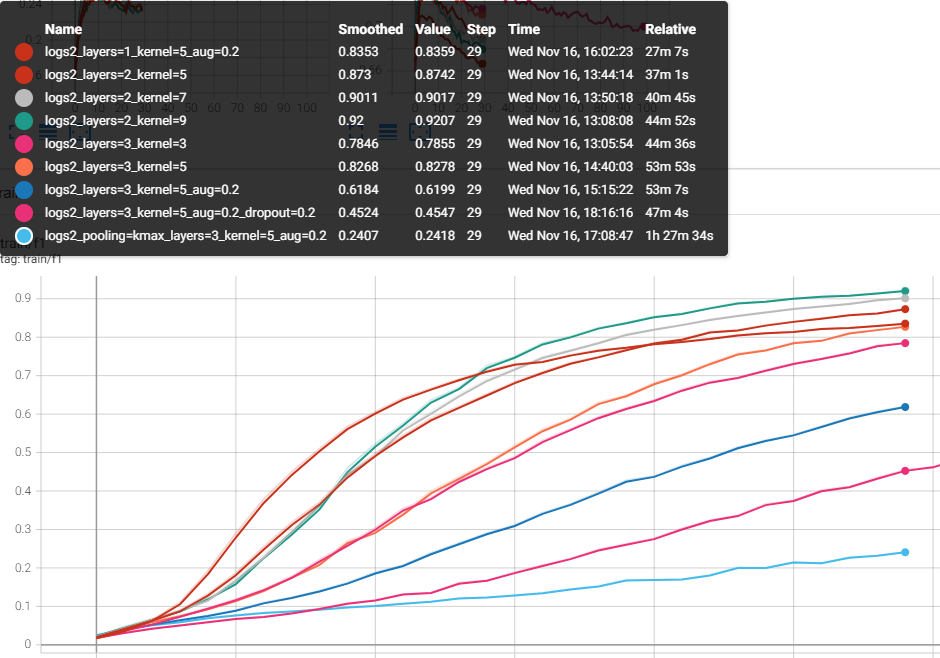

Метрики на валидационной выборке

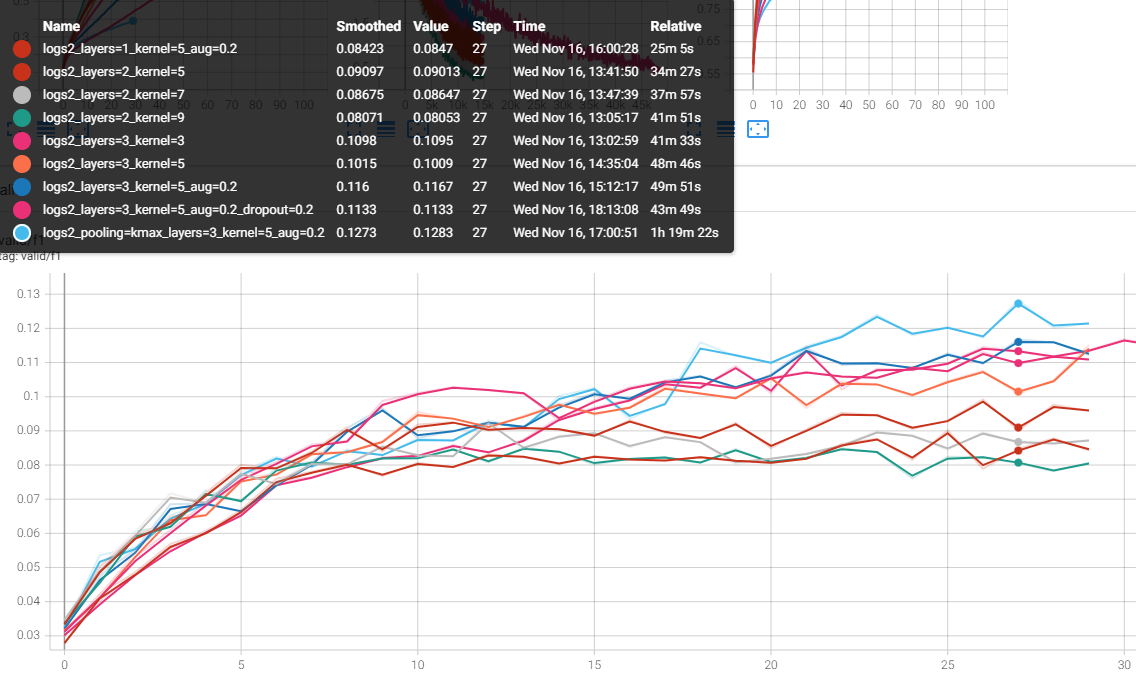

Метрики на тестовой выборке

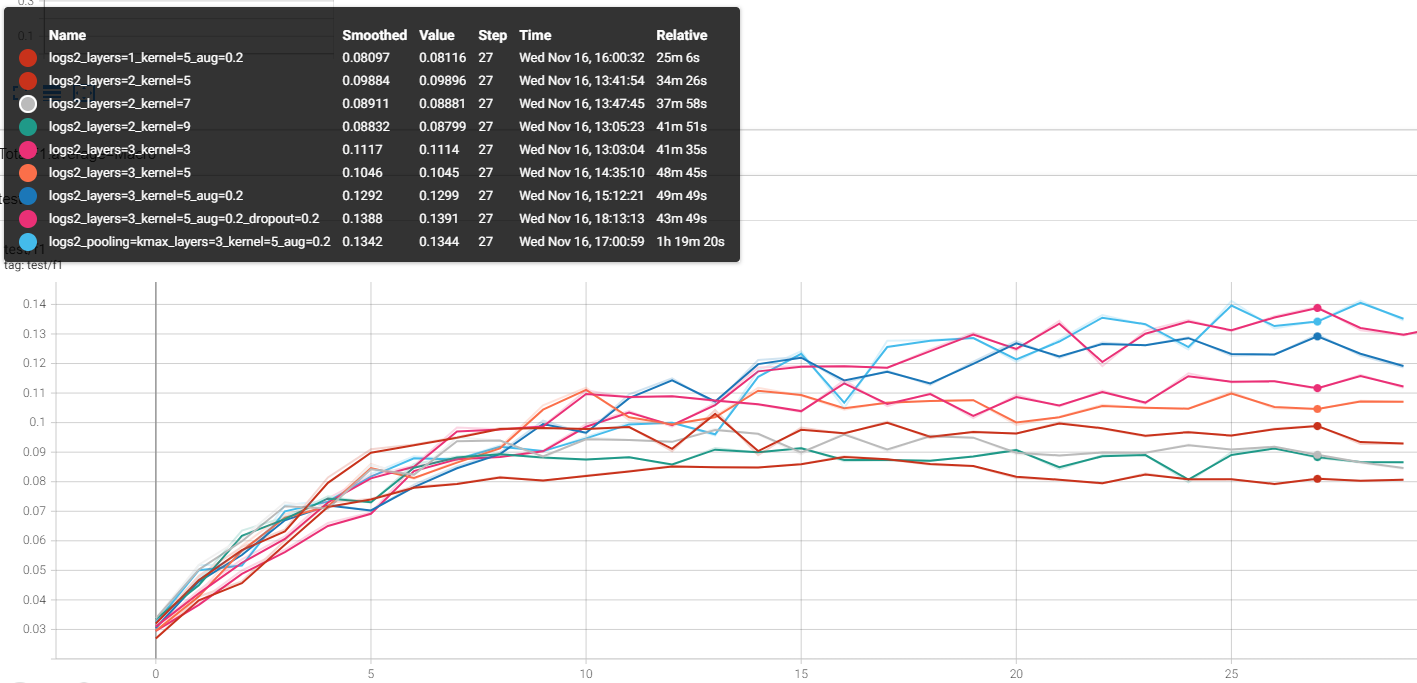

Оптимальным оказалось количество слоев равное 3, а размер ядра - 5.
При меньших параметрах сеть показывала метрики ниже, а при больших - сильно переобучалась.

Kmax pooling и аугментации (синонимы и spatial dropout) позволили снизить переобучение модели под обучающую выборку и повысить качество модели.

Наилучшая модель на валидации (logs2_pooling=kmax_layers=3_kernel=5_aug=0.2, 27 эпоза) показывает 0.1283 f1 macro, а на тестовой выборке 0.1342 f1 macro, что лучше, чем модель fast text.

При этом данная модель имеет на обучении всего 0.24 f1 macro (минимальное из всех моделей), что говорит о низком переобучении. 

### LinearRegression

Обучим линейную регрессию поверх TfIdf на 1 и 2 граммах.
Будем использовать стеммер для нормализации слов.
Откинем очень популярные (замена фильтрации на стоп-слова) и редкие токены.

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer

In [62]:
stem = SnowballStemmer("english")

In [63]:
tfidf = TfidfVectorizer(min_df=10, max_df=0.5, ngram_range=(1, 2), max_features=30000)
x = tfidf.fit_transform([stem.stem(x) for x in tqdm(df_train["text"].values)])

  0%|          | 0/60980 [00:00<?, ?it/s]

In [64]:
x.shape

(60980, 30000)

In [65]:
lr = LogisticRegression(class_weight="balanced", max_iter=200)
lr.fit(x, df_train["target"])

LogisticRegression(class_weight='balanced', max_iter=200)

In [66]:
lr.predict(x)

array(['RIDDIKULUS', 'RIDDIKULUS', 'INCENDIO', ..., 'CONFRINGO',
       'AGUAMENTI', 'POINT_ME'], dtype=object)

In [67]:
for name, sample in [('train', df_train), ('dev', df_dev), ('test', df_test)]:
    predict = lr.predict(tfidf.transform(sample["text"]))
    score = f1_score(
        sample["target"],
        predict,
        average="macro",
    )
    print(f"Sample {name}\tscore:{score:.4f}")

Sample train	score:0.5545
Sample dev	score:0.1492
Sample test	score:0.1686


Полученная модель получила метрики качества выше, чем нейронная сеть, однако модель сильно переобучена под обучающую выборку.

Сравним для нее матрицу смежности для редких и популярных классов

In [68]:
head_classes = list(df_train["target"].value_counts().head(10).index)
tail_classes = list(df_train["target"].value_counts().tail(10).index)

Нормируем матрицу смежности на кол-во класса в выборке (в ячейке находится значение того, какую долю от истинного класса занимает предсказанный класс)

In [74]:
cm = confusion_matrix(sample["target"], predict, labels=df_train["target"].value_counts().index)
cm = cm / cm.sum(axis=1)

/tmp/ipykernel_1672/3023778085.py:2: RuntimeWarning: invalid value encountered in divide
  cm = cm / cm.sum(axis=1)


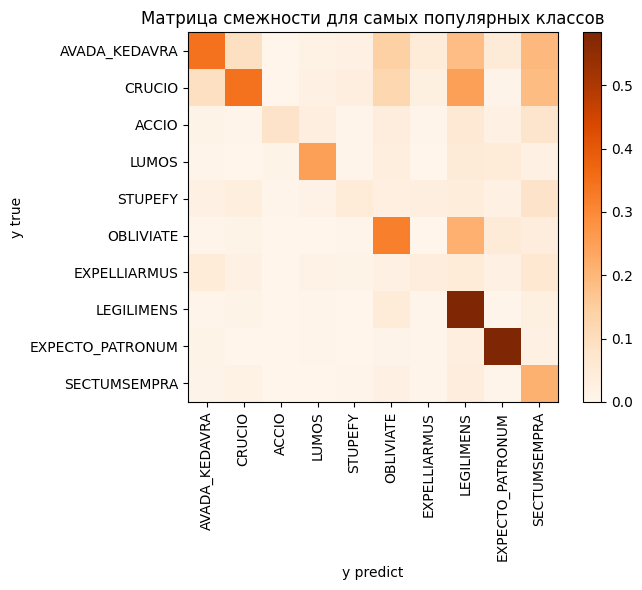

In [82]:
plt.imshow(cm[:10, :10], cmap="Oranges")
plt.colorbar()
plt.title("Матрица смежности для самых популярных классов")
plt.xticks(np.arange(10), head_classes, rotation=90)
plt.yticks(np.arange(10), head_classes)
plt.ylabel("y true")
plt.xlabel("y predict")
plt.show()

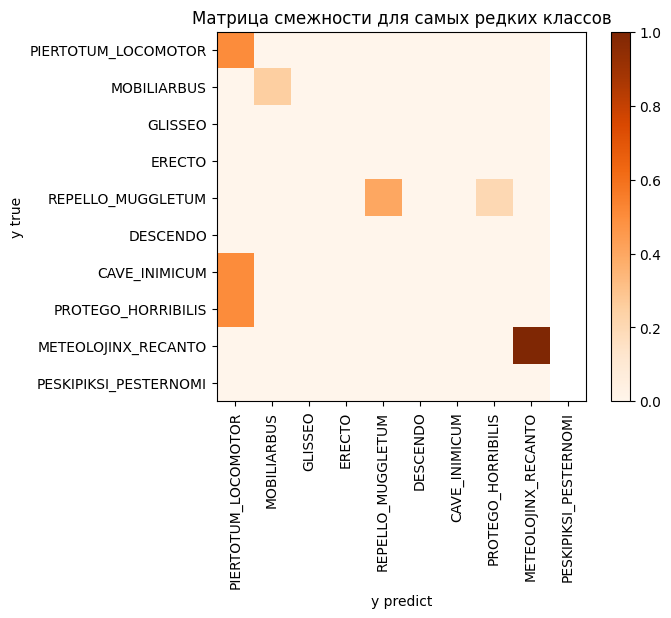

In [84]:
plt.imshow(cm[-10:, -10:], cmap="Oranges")
plt.colorbar()
plt.title("Матрица смежности для самых редких классов")
plt.xticks(np.arange(10), tail_classes, rotation=90)
plt.yticks(np.arange(10), tail_classes)
plt.ylabel("y true")
plt.xlabel("y predict")
plt.show()

**Вывод:**
- для популярных классов просматривается главная диагональ, можно заметить заклинания, которая модель путает
- для редких классов главная диагональ практически незаметна (модель предсказывает мало редких классов и путает их)

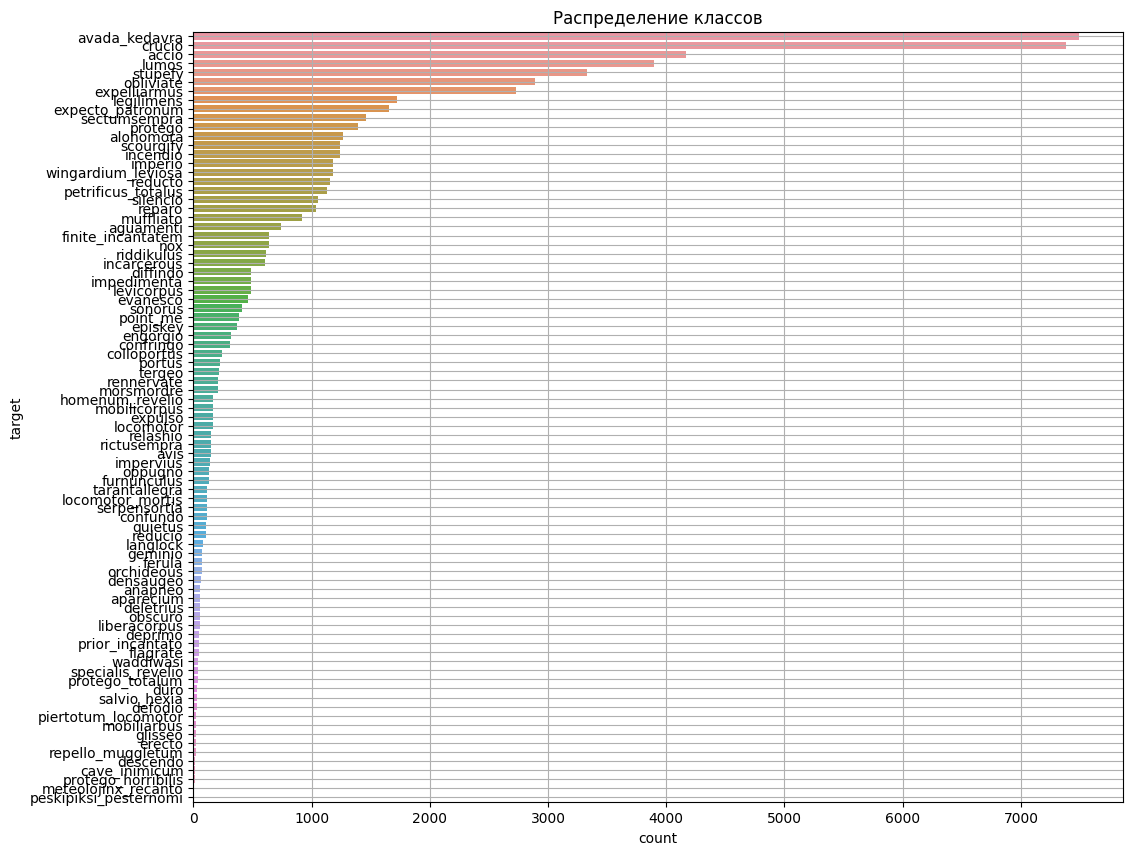

In [102]:
plt.figure(figsize=(12, 10))
sns.countplot(y=df_train["target"].str.lower(), orient="h", order=df_train["target"].str.lower().value_counts().index)
plt.title("Распределение классов")
plt.grid()
plt.show()

### CatBoost (любимый классификатор)

Личная реализация с соревнования https://www.kaggle.com/code/googoogoojoob/simple-efficient-catboost-classifier

In [ ]:
import catboost
from catboost import CatBoostClassifier, Pool

In [ ]:
train_pool = Pool(
    df_train[["text"]],
    label=df_train["target"],
    text_features=["text"],
)

validation_pool = Pool(
    df_dev[["text"]],
    label=df_dev["target"],
    text_features=["text"],
)

test_pool = Pool(
    df_test[["text"]],
    label=df_test["target"],
    text_features=["text"],
)

In [139]:
clf_params = {
    "iterations": 100,
    "eval_metric": "TotalF1:average=Macro",
    "random_seed": 42,
    "grow_policy": "Lossguide",
    "text_processing": {
        "tokenizers": [
            {
                "tokenizer_id": "Space",
                "delimiter": " ",
                "separator_type": "ByDelimiter",
            },
            # {
            #     "tokenizer_id": "Sense",
            #     "separator_type": "BySense",
            # },
        ],
        "dictionaries": [
            {
                "dictionary_id": "Word",
                "max_dictionary_size": "10000",
                "occurrence_lower_bound": "5",
                "gram_order": "1",
            },
            {
                "dictionary_id": "BiGram",
                "max_dictionary_size": "10000",
                "occurrence_lower_bound": "5",
                "gram_order": "2",
            },
            {
                "dictionary_id": "TriGram",
                "token_level_type": "Letter",
                "max_dictionary_size": "10000",
                "occurrence_lower_bound": "10",
                "gram_order": "3",
            },
        ],
        "feature_processing": {
            "default": [
                {
                    "dictionaries_names": ["Word", "BiGram", "TriGram"],
                    "feature_calcers": ["BoW"],
                    "tokenizers_names": ["Space"],
                },
                # {
                #     "dictionaries_names": ["Word", "BiGram"],
                #     "feature_calcers": ["BoW", "BM25"],
                #     "tokenizers_names": ["Sense"],
                # },
                # {
                #     "dictionaries_names": ["Word", "TriGram"],
                #     "feature_calcers": ["NaiveBayes", "BM25"],
                #     "tokenizers_names": ["Sense"],
                # },
                {"dictionaries_names": ["Word"], "feature_calcers": ["BoW"], "tokenizers_names": ["Space"]},
            ],
        },
    },
}

In [140]:
m = CatBoostClassifier(**clf_params)
m.fit(train_pool, eval_set=validation_pool, verbose=10, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.282509
0:	learn: 0.0202939	test: 0.0198263	best: 0.0198263 (0)	total: 6.25s	remaining: 10m 18s
10:	learn: 0.0425141	test: 0.0399775	best: 0.0399775 (10)	total: 1m 7s	remaining: 9m 9s
20:	learn: 0.0534467	test: 0.0510537	best: 0.0510537 (20)	total: 2m 8s	remaining: 8m 4s
30:	learn: 0.0605746	test: 0.0573644	best: 0.0573644 (30)	total: 3m 10s	remaining: 7m 3s
40:	learn: 0.0681308	test: 0.0613467	best: 0.0613467 (40)	total: 4m 11s	remaining: 6m 2s
50:	learn: 0.0762634	test: 0.0634764	best: 0.0634764 (50)	total: 5m 11s	remaining: 4m 59s
60:	learn: 0.0808045	test: 0.0707353	best: 0.0707353 (60)	total: 6m 10s	remaining: 3m 56s
70:	learn: 0.0835212	test: 0.0715726	best: 0.0715726 (70)	total: 7m 8s	remaining: 2m 54s
80:	learn: 0.0874698	test: 0.0741238	best: 0.0744946 (78)	total: 8m 2s	remaining: 1m 53s
90:	learn: 0.0918537	test: 0.0785325	best: 0.0788292 (88)	total: 8m 56s	remaining: 53s
99:	learn: 0.0948173	test: 0.0778819	best: 0.0789362 (95)	total: 9m 43s	remaining: 

In [141]:
preds = m.predict(test_pool)

In [142]:
for name, sample in [("train", train_pool), ("dev", validation_pool), ("test", test_pool)]:
    predict = m.predict(sample)
    score = f1_score(
        sample.get_label(),
        predict,
        average="macro",
    )
    print(f"Sample {name}\tscore:{score:.4f}")

Sample train	score:0.0935
Sample dev	score:0.0808
Sample test	score:0.0766


CatBoost показал низкие метрики качества, однако такой подход можно использовать как вспомогательный при наличии большого количества табличных данных.

## Часть 4. [1 балл] Итоги
Напишите краткое резюме проделанной работы. Читали ли вы сами Гарри Поттера или фанфики о нем и помогло ли вам знание предметной области в выполнении домашнего задания?

В результате анализа топ самых популярных слов и пар были выявлены закономерности в предлагаемых текстах.

В работе была обучена unsupervised cbow fastText модель для представлений слов на материалах корпуса HPAC.
Была проведена визуализация эмбеддингов слов с помощью TSNE и изучены свойства полученных векторов - результаты объяснимы и соответствуют ожиданиям.

При решении задачи классификации были обучены модели fastText, сверточные нейронные сети, линейная регрессия поверх TfIdf признаков, CatBoost.
Наилучшей моделью оказалась линейная регрессия, однако нейронная сеть получилась наименнее переобученной.
Был выполнен подбор гиперпараметров для сети; использование аугментаций (замена слов на синонимы, зануление случайных слов) и kmax pooling помогло сущейственно снизить переобучение модели нейронной сети и улучшить метрики для модели.

Гарри Поттера не читали, для выполнения задания хватило общеизвестной информации и краткого изложения с Википедии.